# Assignment 5 - Policy Gradient Methods

Before you start with this problem:
- Study the corresponding slide deck(s) and consider re-watching the lecture recording(s).
- Internalize the material until you feel confident you can work with them or implement them yourself. Only then start working on this assignment; otherwise, you will waste a lot of time.

---

<div class="alert alert-warning">

**Due-Date:** see Moodle
   
**Constraints**: Operations on SciPy, NumPy, Torch arrays/ tensors only.
  
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- make sure to remove all `raise NotImplementedError()` statements
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete cells.
    
**Submission:** Submit the notebook via Moodle.
- naming convention: `k<8 digits of student ID>.ipynb`
- correct naming for student with id k01234567: k01234567.ipynb
- some examples of incorrectly named submissions:
    - k1234567.ipynb (7 digits)
    - k01234567.pdf (converted to pdf)
    - k01234567.html (converted to html)
    - 01234567.ipynb (k is missing)
    - k01324567.ipynb (incorrect student ID)
    -  ...
- notbooks that cannot be assign automatically will not be graded

**Question?** Post it into the forum!
</div>


In this assignment we will solve the Cartpole balancing problem using the **Policy Gradient Method REINFORCE**.<br>

In particular we will use a neural network to approximate our policy $\pi(a|s)$. To that end we will rely on an auto-differentiation framework which will provide us with the gradients of our policy with respect to its parameters.

You will use the **PyTorch** framework for this exercise, so please install this package: <br/> `$ conda install pytorch==2.4.1 cpuonly -c pytorch`<br>

In [69]:
# uncomment and run if pytorch is not installed in your environement
#!conda install pytorch==2.4.1 cpuonly -c pytorch

In [70]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import testing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.nn.init import calculate_gain

from typing import Union, Tuple

### A helper function to convert seeds from a seed sequence to python `int`s:

In [71]:
def seed_adapter(seed_sequence: np.random.SeedSequence) -> int:
    # spawn a new child generator from the seed_sequence
    child = seed_sequence.spawn(1)[0]

    # generate a random seed
    seed_uint64 = child.generate_state(1, np.uint64)[0]

    # torch and the numpy PRNGs used in the openai gym want a python 'int', not a 'numpy.uint64'!
    seed_int = int(seed_uint64)

    print('seed_int', seed_int)
    return seed_int

### Some helper functions to initialize the weights of neural networks:

In [72]:
def relu_init(m: torch.nn.Linear) -> None:
    # print('relu_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='relu'
    )
    nn.init.constant_(m.bias.data, 0.)


def linear_init(m: torch.nn.Linear) -> None:
    # print('linear_init', m)
    nn.init.kaiming_normal_(
        m.weight.data, 0.,
        mode='fan_in',
        nonlinearity='linear'
    )
    nn.init.constant_(m.bias.data, 0.)


def softmax_init(m: torch.nn.Linear) -> None:
    # print('softmax_init', m)
    nn.init.xavier_normal_(m.weight.data, calculate_gain('sigmoid'))
    nn.init.constant_(m.bias.data, 0.)

### Neural network definitions for a policy $\pi_{\Theta}(a | s)$, and a state value function $V_{\Phi}(s)$:

In [73]:
class PolicyNet(nn.Module):
    def __init__(self, n_in: int, n_out: int) -> None:
        super(PolicyNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=1)
        )
        relu_init(self.net[0])
        softmax_init(self.net[2])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ValueNet(nn.Module):
    def __init__(self, n_in: int, n_out: int) -> None:
        super(ValueNet, self).__init__()
        n_hidden = 128
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(inplace=False),
            nn.Linear(n_hidden, n_out),
        )
        relu_init(self.net[0])
        linear_init(self.net[2])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### Helper function to compute (standardized) returns:

In [74]:
def compute_returns(rewards: torch.Tensor, gamma: float) -> list[float]:
    returns = []
    G = 0
    for r in rewards[::-1]:
        G = r + gamma * G
        returns.insert(0, G)
    
    # this is a trick that is often used, when we
    # use function approximators to learn values
    # or policies: the returns are standardized to
    # have a mean value of 0, and a stddev of 1.
    # this has a stabilizing effect on training.
    returns = np.array(returns)
    returns = returns - returns.mean()
    returns = returns / returns.std()
    return returns

### A helper function that visualizes an episode:
We'll see after the definition of agent, how to use this.

In [75]:
def visualize_episode(gamma: float, episode: dict, losses: dict=dict()) -> None:
    states = np.array(episode['states'])
    actions = np.array(episode['actions'])
    rewards = np.array(episode['rewards'])
    
    if 'values' in episode:
        values = torch.cat(episode['values']).squeeze().detach().numpy()
    else:
        values = np.full_like(rewards, np.nan, dtype=float)

    if len(losses) > 0 and 'policy_losses' in losses:
        p_losses = losses['policy_losses'].detach().numpy()
    else:
        p_losses = np.full_like(rewards, np.nan, dtype=float)
        
    if len(losses) > 0 and 'value_losses' in losses:
        v_losses = losses['value_losses'].detach().numpy()
    else:
        v_losses = np.full_like(rewards, np.nan, dtype=float)

    returns = compute_returns(episode['rewards'], gamma)

    deltas = returns - values
    linestyle = '-'

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 6), sharex=True)
    ax = axes[0, 0]
    ax.set_title('states')
    ax.plot(states[:, 0], linestyle=linestyle, marker='.', label='cart position')
    ax.plot(states[:, 1], linestyle=linestyle, marker='.', label='cart velocity')
    ax.plot(states[:, 2], linestyle=linestyle, marker='.', label='pole angle')
    ax.plot(states[:, 3], linestyle=linestyle, marker='.', label='pole angular velocity')
    ax.legend()
    
    ax = axes[0, 1]
    ax.set_title('actions (from policy net)')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['left', 'right'])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(actions, linestyle=' ', marker='.')

    ax = axes[1, 0]
    ax.set_title('rewards')
    ax.set_yticks([0, 1])
    ax.set_ylim([-0.1, 1.1])
    ax.plot(rewards, linestyle=linestyle, marker='.')

    ax = axes[1, 1]
    ax.set_title('values vs. returns')
    ax.plot(values, linestyle=linestyle, marker='.', label='values')
    ax.plot(returns, linestyle=linestyle, marker='x', label='returns')
    ax.legend()

    ax = axes[2, 0]
    ax.set_title('policy & value losses')
    ax.plot(p_losses, linestyle=linestyle, marker='.', label='policy loss')
    ax.plot(v_losses, linestyle=linestyle, marker='.', label='value loss')
    ax.legend()

    ax = axes[2, 1]
    ax.set_title('deltas (returns - values)')
    ax.plot(deltas, linestyle=linestyle, marker='.')

    for ax in axes.flatten():
        h = len(states) // 2
        m = len(states)
        ax.set_xticks([0, h, m])

    # all axes in the bottom row
    for ax in axes[-1, :].flatten():
        ax.set_xlabel('timestep t')
    plt.tight_layout()
    plt.show()

## The class definition of the REINFORCE agent
This is a partial definition of an RL agent that is supposed to implement the REINFORCE algorithm. You will implement the agent step-by-step. Look at the TODOs, and the later cells, and follow each step. At the end of each step, you should have a fully functional agent, that is able to learn to balance a pole on a cart.

In [76]:
class REINFORCEAgent():
    def __init__(self, env: gym.Env, alpha: float):
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.optimizer = optim.Adam(
            self.policy.parameters(),
            lr=alpha,
        )
        
    def get_action_and_log_prob(self, state: int) -> Tuple[int, float]:
        pass

    def generate_episode(self, env: gym.Env) -> dict:
        pass

    def update(self, episode: dict, gamma: float) -> None:
        pass

## (1) Implement action selection

<div class="alert alert-warning">
    Implement the missing parts in get_action_and_log_prob. (2 points)
</div>

The first thing you will need to do is to implement action selection with a <b>parametrized policy</b>. Look at `get_action_and_log_prob(self, state)`, implement all the `TODO`s, and then try to execute the code cell below:

Hint: Use the ['Categorical' distribution class](https://pytorch.org/docs/stable/distributions.html#categorical) in pytorch.

In [77]:
def get_action_and_log_prob(self, state: int) -> Tuple[int, torch.Tensor]:
    """
    Samples a single action from the policy net.
    
    Args:
        state: the state to sample the action for
    
    Returns:
        a tuple containing the sampled action and the log probability of the selected action
    """
    # get the state as a pytorch tensor, bring it into the right format
    state = torch.from_numpy(state).float().unsqueeze(0)

    # TODO
    # use the policy network to get the distribution pi(a | s), and
    # sample an action from this distribution
    # hint: (use the policy network `self.policy` and the 'Categorical(probs=probabilities)' distribution class in pytorch)
    # YOUR CODE HERE
    # Get action probabilities from policy network
    probs = self.policy(state)
    
    # Create distribution and sample action
    pi = Categorical(probs=probs)
    action = pi.sample().item()
    
    # TODO
    # return both the sampled action, and its log-probability
    # hint: use the the same 'Categorical' distribution object you used to sample the action, e.g., pi.sample()
    # YOUR CODE HERE
    # Get log probability of the sampled action
    log_prob_of_action = pi.log_prob(torch.tensor(action))
    
    return action, log_prob_of_action

REINFORCEAgent.get_action_and_log_prob = get_action_and_log_prob

In [78]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(1)

env = gym.make('CartPole-v1')

torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)

# let's get the starting state of the environment
state, _ = env.reset(seed=seed_adapter(seed_sequence))

# now we'll test the action selection method
action, log_prob = agent.get_action_and_log_prob(state)

# this should be an integer
print('action:', action, type(action))

# and this should be a torch tensor with a 'grad_fn' field
print('log_prob:', log_prob, type(log_prob))

assert testing.is_type(action, int)
assert testing.is_type(log_prob, torch.Tensor)
assert log_prob.shape == (1,), "Remove the empty dimensions!"


seed_int 8431846347943309920
seed_int 4042681867674859579
action: 1 <class 'int'>
log_prob: tensor([-0.6901], grad_fn=<SqueezeBackward1>) <class 'torch.Tensor'>


### The expected output of the previous cell should look exactly like this:
```
seed_int 8431846347943309920
seed_int 4042681867674859579
action: 1 <class 'int'>
log_prob: tensor([-0.6901], grad_fn=<SqueezeBackward1>) <class 'torch.Tensor'>
```

## (2) Implement episode generation

<div class="alert alert-warning">
    Implement the missing parts in generate_episode. (2 points)
</div>

Now that we can select an action, given a state, let's see if we can generate an episode. Look at `generate_episode(self, env)`, implement all the `TODO`s, and then try to execute the code cell below.<br>

**When you are debugging, keep the possibility to visualize episodes (and later on losses as well) in mind!**

In [79]:
def generate_episode(self, env: gym.Env) -> dict:
    """
    Gernerates a single episode.
    
    Args:
        env: the openai gym environment
    
    Returns:
        a dicitonary with states, actions, rewards, and log probabilites
    """
    states = []
    actions = []
    log_probs = []
    rewards = []

    done = False
    truncated = False
    state, _ = env.reset()
      
    # TODO
    # here, you'll interact with the episodic environment, and generate
    # an episode. use the method 'self.get_action_and_log_prob' you implemented above!
    # recall: next_state, reward, done, truncated, _ = env.step(action)
    # IMPORTANT: stop the episode if done OR truncated is true!
    # you will need to record for later:
    # - a list of states (including S_0, excluding terminal state)
    # - a list of actions (starting with A_0)
    # - a list of the log probabilities of the actions (strarting with the log_probability corresponding to A_0)
    # - a list of rewards (starting with the first reward R_1)

    # YOUR CODE HERE
    while not (done or truncated):
        # Store current state
        states.append(state)
        
        # Get action and its log probability
        action, log_prob = self.get_action_and_log_prob(state)
        
        # Execute action in environment
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Store action, reward and log probability
        actions.append(action)
        rewards.append(float(reward))
        log_probs.append(log_prob)
        
        state = next_state
            
    return dict(
        states=states,
        actions=actions,
        rewards=rewards,
        log_probs=log_probs
    )

REINFORCEAgent.generate_episode = generate_episode

seed_int 3890642289391122579
seed_int 13194552230369835111


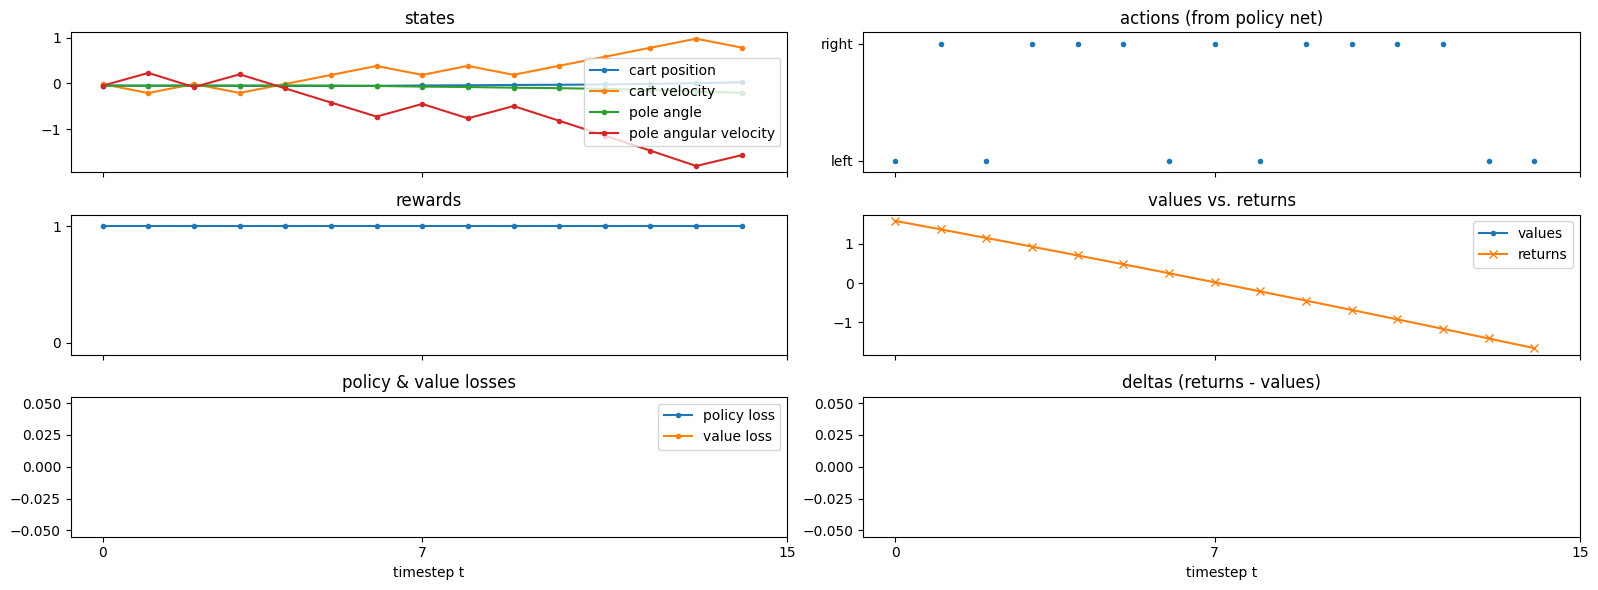

In [80]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(2)

env = gym.make('CartPole-v1')

state = env.reset(seed=seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]
assert all(np.isclose(episode['states'][0], np.array([-0.045995, -0.01340714, -0.04928517, -0.04744625]), atol=1e-5)), "First state in the list must be S_0."

visualize_episode(gamma, episode)

### The seed should be:
```
seed_int 3890642289391122579
seed_int 13194552230369835111
```

## (3) Implement the REINFORCE update

<div class="alert alert-warning">
    Implement the missing parts in update. (4 points)
</div>

Now that we made sure we can generate an episode, your next task is to implement the REINFORCE update. Look at `update(self, episode, gamma)`, implement all the `TODO`s, and then try to execute the code cell below.

In [81]:
def update(self, episode: dict, gamma: float) -> dict:
    """
    Updates the policy network and returns a dictionary with the overall loss and the loss at each step  
    
    Args:
        episode: a dicitonary with states, actions, rewards, and log probabilites
        gamma: the discount factor
    
    Returns:
        a dicitonary with the loss at each state and the overall loss
    """   
    # use this list to keep track of the loss terms at the individual steps
    policy_losses = []
    
    # TODO compute returns by calling `compute_returns(rewards, gamma)`, as it
    # already includes the return standardization
    # YOUR CODE HERE
    returns = compute_returns(episode['rewards'], gamma)
    
    # TODO: loop through the episode, compute the loss terms for the individual steps
    #
    # please note, that the pseudo code in the book/on the slides gives the vanilla SGD
    # update rule already. what you need to do now, is to specify individual loss terms for
    # each step. these loss terms will lead to the desired gradients when we use
    # `policy_loss.backward()` later on.
    # append each individual loss term to the list `policy_losses` with the `append` method
    #
    # please also note that each individual loss term needs to include the `gamma ** t` term
    # from the REINFORCE pseudo code given in the book, page 328!
    # YOUR CODE HERE
    for t in range(len(episode['rewards'])):
        # The policy gradient loss includes gamma^t * G_t * log_prob
        policy_losses.append(-gamma**t * returns[t] * episode['log_probs'][t])
    
    
    # -----------------------------------------------------------------------------------
    # --- the code below does not need to be changed ------------------------------------
    # -----------------------------------------------------------------------------------
    # this resets the gradients on all involved weight tensors
    self.optimizer.zero_grad()

    # this concatenates all individual policy loss terms
    policy_losses = torch.cat(policy_losses)
        
    # here we sum all policy losses up. this implements the gradient accumulation
    # "theta = theta + ..." from the pseudo code, where it says
    # "loop for each step of the episode ..." in one neat line.
    policy_loss = policy_losses.sum()

    # this computes the gradient of the loss wrt all involved weight tensors
    policy_loss.backward()

    # this updates the weight tensors with the update rule of the optimizer
    # we're not using vanilla SGD here, but rather the Adam update rule,
    # as it converges much, much faster
    self.optimizer.step()
        
    # finally, we'll return the policy_loss for visualization purposes later on
    return dict(
        policy_loss=policy_loss.item(),
        policy_losses=policy_losses
    )

REINFORCEAgent.update = update

seed_int 14449357594836781232
seed_int 18443715169928553612


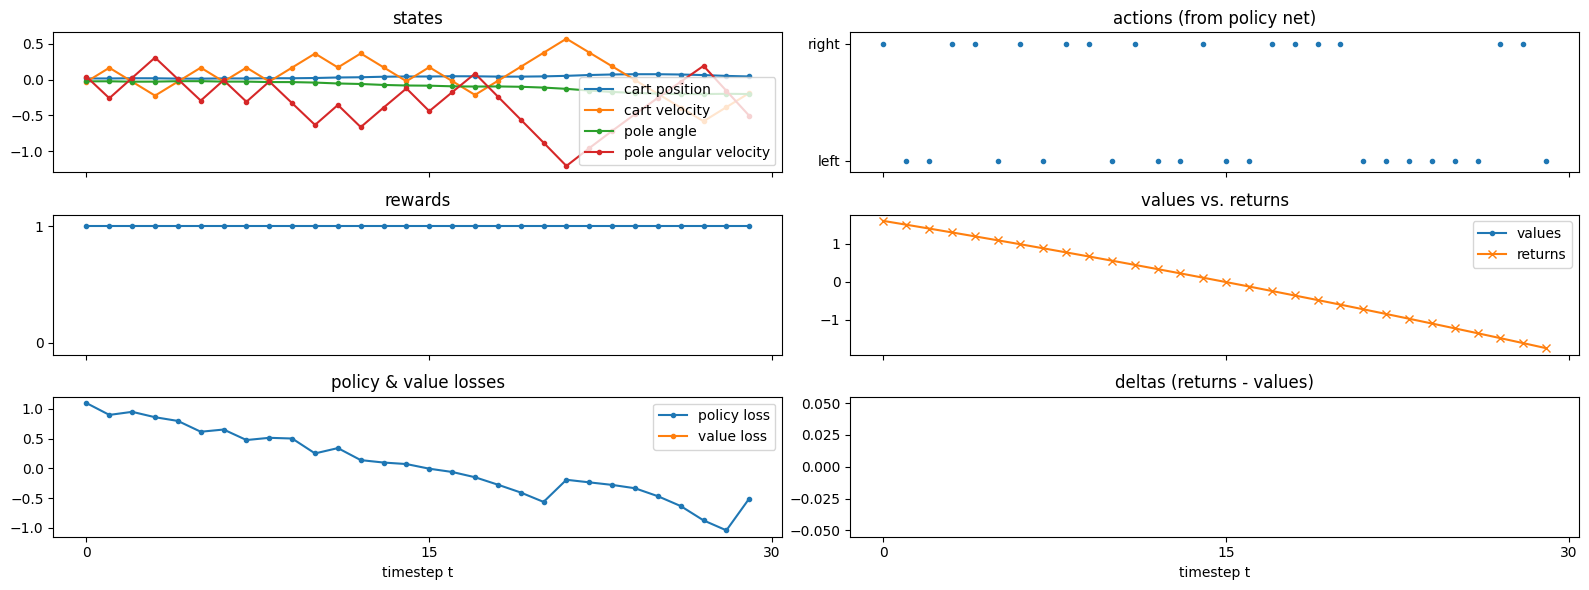

In [82]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')

state = env.reset(seed=seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCEAgent(env, alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]

losses = agent.update(episode, gamma)

assert testing.is_type(losses['policy_loss'], float)
assert testing.is_type(losses['policy_losses'], torch.Tensor)

visualize_episode(gamma, episode, losses)

### The expected seed of the previous cell is:
```
seed_int 14449357594836781232
seed_int 18443715169928553612
```

### Making sure REINFORCE learns something useful
Let's train it for 200 episodes, and see what it has learned.

seed_int 16363712187084821697
seed_int 7001527192274380292


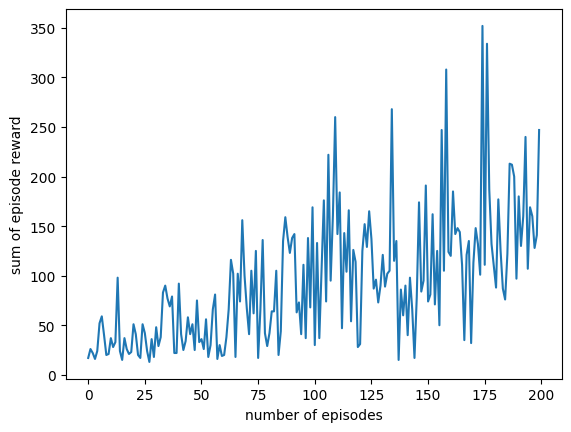

In [83]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(4)

env = gym.make('CartPole-v1')
state = env.reset(seed=seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCEAgent(env, alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### The expected seed of the previous cell is:
```
seed_int 16363712187084821697
seed_int 7001527192274380292
```

### Let's look at a generated episode, after the agent has trained for 200 episodes:

seed_int 14449357594836781232
seed_int 18443715169928553612


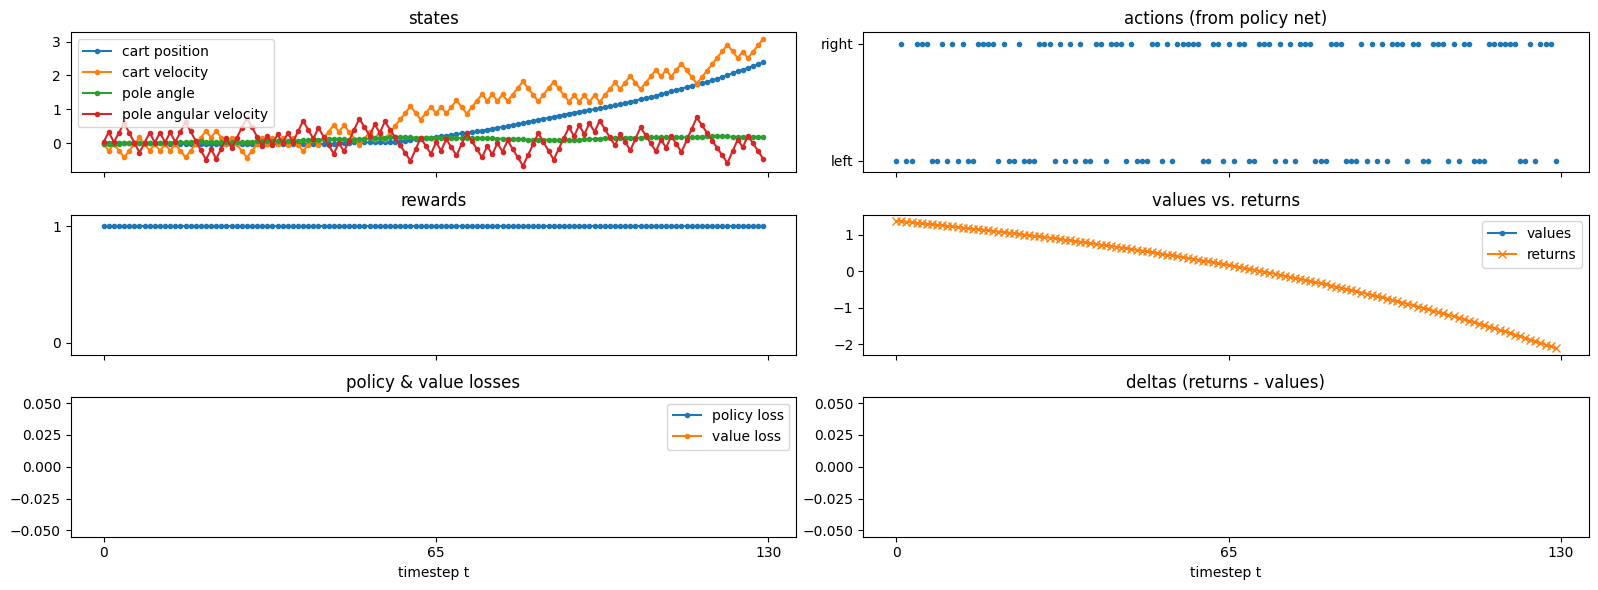

In [84]:
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')
state = env.reset(seed=seed_adapter(seed_sequence))

# this needs to be set before generating an episode, as it governs the sampling happening in the `Categorical` distribution
torch.manual_seed(seed_adapter(seed_sequence))
episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

### The expected seed of the previous cell is:
```
seed_int 14449357594836781232
seed_int 18443715169928553612
```

## (4) Computational experiments with REINFORCE

You will now have to run a small set of computational experiments with your REINFORCE implementation. You will have a look at three different parameterizations of the learning rate `alpha` (see below).<br>

We'll define a helper function first, that does a lot of the boring steps for you already. It takes in a `SeedSequence` for reproducibility, a discount factor `gamma`, the number of runs `n_runs`, and the number of episodes per run `n_episodes`.<br>

Furthermore it takes a type `agent_class`, and a dictionary `agent_params`, so it can instantiate a new agent for each run.<br>

`log_interval` specifies how often an intermediate result is displayed.

In [85]:
# a helper function that runs computational experiments
def run_experiments(seed_sequence,
                    env,
                    gamma,
                    n_runs,
                    n_episodes,
                    agent_class,
                    agent_params,
                    log_interval=50):
    print('-' * 60)
    print('agent_class', agent_class)
    print('agent_params', agent_params)
    state = env.reset(seed=seed_adapter(seed_sequence))
    torch.manual_seed(seed_adapter(seed_sequence))
    
    # return np.zeros((n_runs, n_episodes))
    
    import sys
    run_rewards = []
    for i_run in range(n_runs):
        # at the start of each run, we instantiate a new agent
        agent = agent_class(**agent_params)
        episode_rewards = []
        for i_episode in range(n_episodes):
            episode = agent.generate_episode(env)
            losses = agent.update(episode, gamma)
            episode_rewards.append(np.sum(episode['rewards']))
            
            # "make sure we can watch optimizer TV", i.e. display progress, and
            # do some fancy logging, so that we have the feeling that something
            # is happening, while we are waiting ... :)
            if i_episode % log_interval == 0 or i_episode == n_episodes - 1:
                out = f'run:{i_run}/{n_runs} ep:{i_episode:>04d}/{n_episodes} '
                for name, value in losses.items():
                    if name.endswith('_loss'):
                        out += f'{name}:{value:04.2f} '
                out += f'avg reward last 10 episodes:{np.mean(episode_rewards[-10:])}'
                
                # overwrite what's already been written
                sys.stdout.write('\r' + ' ' * 400)
                # write 'out' to stdout
                sys.stdout.write(f'\r{out}')
                sys.stdout.flush()

        run_rewards.append(episode_rewards)
    print()
    # this returns an array with the sum of rewards for each episode.
    # it is shaped like this: (n_runs, n_episodes)
    return np.array(run_rewards)

# a helper function for plotting later on
def plot(ax, rewards, label):
    mean_rewards = np.mean(rewards, axis=0)
    std_rewards = np.std(rewards, axis=0)
    ax.fill_between(
        np.arange(rewards.shape[1]),
        np.maximum(1, mean_rewards - std_rewards),    # sums smaller than 1 are impossible
        np.minimum(500, mean_rewards + std_rewards),  # sums larger than 500 are impossible
        alpha=0.4  # this specifies transparency of the area that's filled in
    )
    ax.plot(mean_rewards, label=label)

### Run three experiments

<div class="alert alert-warning">
    Run three experiments with different learning rates (as defined below). (2 points)
</div>

You will now run three computational experiments, each with a different learning rate `alpha`. The alphas are already given in the code cell below.<br>

Use the function `run_experiments`, and collect the `run_rewards` for each run produced by a different learning rate. You'll need to plot these in the next step.

In [86]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(5)

env = gym.make('CartPole-v1')

n_runs = 5
n_episodes = 500
alphas = [1e-4, 1e-3, 1e-2]

# TODO: run three separate experiments, one with each alpha specified above
run_rewards = dict()
for alpha in alphas:
    #run_rewards[alpha] = None
    # YOUR CODE HERE
    run_rewards[alpha] = run_experiments(
        seed_sequence=seed_sequence,
        env=env,
        gamma=gamma,
        n_runs=n_runs,
        n_episodes=n_episodes,
        agent_class=REINFORCEAgent,
        agent_params={'env': env, 'alpha': alpha}
    )

------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>, 'alpha': 0.0001}
seed_int 15658875773272509128
seed_int 6924645418555453511
run:4/5 ep:0499/500 policy_loss:7.87 avg reward last 10 episodes:50.9                                                                                                                                                                                                                                                                                                                                           
------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>, 'alpha': 0.001}
seed_int 1725439304048894018
seed_int 13230002727910310950
run:4/5 ep:0499/500 policy_loss:32.17 avg re

In [87]:
assert all([testing.is_type(run_rewards[a], np.ndarray) for a in alphas])
assert all([run_rewards[a].shape == (n_runs, n_episodes) for a in alphas])

### Plot the outcomes of the three experiments

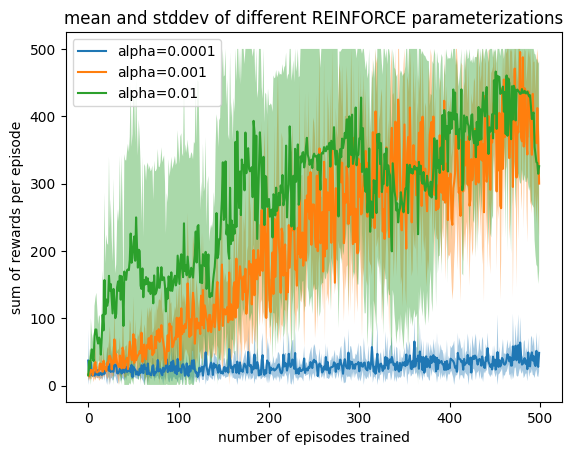

In [88]:
fig, ax = plt.subplots()
ax.set_title('mean and stddev of different REINFORCE parameterizations')
ax.set_ylabel('sum of rewards per episode')
ax.set_xlabel('number of episodes trained')
for alpha, rewards in run_rewards.items():
    plot(ax, rewards, label=f'alpha={alpha}')
ax.legend()
plt.show()

## The class definition of the REINFORCE agent with Baseline
Here you will need to add a baseline to the REINFORCE agent. You can reuse (and **adapt**!) some code parts from your REINFORCE implementation --- just copy them from above.

In [89]:
class REINFORCE_BL_Agent():
    def __init__(self, env, policy_alpha, value_alpha):
        # this agent provides the option of optimizing
        # the policy net and the value net with different learning rates
        self.n_actions = env.action_space.n
        self.n_observation = list(env.observation_space.shape)[0]

        self.policy = PolicyNet(self.n_observation, self.n_actions)
        self.policy_optimizer = optim.Adam(
            self.policy.parameters(),
            lr=policy_alpha
        )

        self.value = ValueNet(self.n_observation, 1)
        self.value_optimizer = optim.Adam(
            self.value.parameters(),
            lr=value_alpha
        )

    def get_action_and_log_prob(self, state: int) -> Tuple[int, float]:
        pass

    def get_value(self, state: int):
        pass

    def generate_episode(self, env: gym.Env) -> dict:
        pass

    def update(self, episode: dict, gamma: float) -> None:
        pass
    
# we can reuse this one from above
REINFORCE_BL_Agent.get_action_and_log_prob = REINFORCEAgent.get_action_and_log_prob

## (5) Implement get_value

<div class="alert alert-warning">
    Implement the missing parts in get_value for REINFORCE with Baseline. (2 points)
</div>


In [90]:
def get_value(self, state: int) -> torch.Tensor:
    """
    Evaluates the value net on the state that is passed in.
    
    Args:
        state: the state to sample the action for
    
    Returns:
        the value estimate
    """
    # YOUR CODE HERE
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    value = self.value(state_tensor)
    value = value.view(1)
    return value

REINFORCE_BL_Agent.get_value = get_value

In [91]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(1)

env = gym.make('CartPole-v1')

torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)

# let's get the starting state of the environment
state, _ = env.reset(seed=seed_adapter(seed_sequence))

# now we'll test the action selection method
action, log_prob = agent.get_action_and_log_prob(state)

# now we'll get the value
value = agent.get_value(state)

assert testing.is_type(value, torch.Tensor)
assert value.shape == (1,), "Remove the empty batch dimension!"


seed_int 8431846347943309920
seed_int 4042681867674859579


### The expected seed of the previous cell is:
```
seed_int 8431846347943309920
seed_int 4042681867674859579
```

## (6) Implement generate_episode for REINFORCE with baseline
<div class="alert alert-warning">
    Implement the missing parts in generate_episode for REINFORCE with Baseline. (2 points)
</div>

In [ ]:
def generate_episode(self, env: gym.Env) -> dict:
    """
    Gernerates a single episode and records the values for each state.
    
    Args:
        env: the openai gym environment
    
    Returns:
        a dicitonary with states, actions, rewards, the values and log probabilites
    """
    states = []
    actions = []
    log_probs = []
    rewards = []
    values = []

    done = False
    truncated = False
    state, _ = env.reset()
      
    # TODO: this time you'll also need to record value estimates for each step!
    # here, you'll interact with the episodic environment, and generate
    # an episode. use the method 'self.get_action_and_log_prob' you implemented above!
    # recall: next_state, reward, done, truncated _ = env.step(action)
    # IMPORTANT: stop the episode if done OR truncated is true!
    # you will need to record for later:
    # - a list of states (including S_0, excluding terminal state)
    # - a list of actions (starting with A_0)
    # - a list of the log probabilities of the actions (starting with the log probability of A_0)
    # - a list of rewards (starting with R_1)
    # - a list of values (starting with the value of S_0)
    
    # YOUR CODE HERE
    while not (done or truncated):
        states.append(state)
        
        # Get action, log probability and value
        action, log_prob = self.get_action_and_log_prob(state)
        log_prob.squeeze()
        value = self.get_value(state)
        
        next_state, reward, done, truncated, _ = env.step(action)
        
        actions.append(action)
        rewards.append(float(reward))
        log_probs.append(log_prob)
        values.append(value.unsqueeze(0))
        
        state = next_state

    return dict(
        states=states,
        actions=actions,
        rewards=rewards,
        log_probs=log_probs,
        values=values
    )

REINFORCE_BL_Agent.generate_episode = generate_episode

In [ ]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(2)

env = gym.make('CartPole-v1')

state, _ = env.reset(seed=seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)
assert testing.is_type(episode['values'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]
assert [testing.is_type(s, torch.Tensor) for s in episode['values']]

assert all(np.isclose(episode['states'][0], np.array([ -0.045995,   -0.01340714, -0.04928517, -0.04744625]), atol=1e-4)), "First state in the list must be S_0."
assert all(torch.isclose(episode['values'][0], torch.tensor([-0.0551]), atol=1e-4)), "First value in list must be for S_0."


### The expected seed of the previous cell is:
```
seed_int 3890642289391122579
seed_int 13194552230369835111
```

## (7) Implement update for REINFORCE with baseline

<div class="alert alert-warning">
    Implement the missing parts in update for REINFORCE with Baseline. (4 points)
</div>


**Hint**: when you scale the individual policy loss terms by delta = (G - V), make sure to `detach()` the value estimate, so your policy loss term does not produce gradients for the value network. look up the pytorch documentation for details of `detach()`.

In [100]:
def update(self, episode: dict, gamma: float) -> dict:
    """
    Updates the policy and value networks and returns 
    a dictionary with the overall loss and the loss at 
    each step for the policy and value nets.
    
    Args:
        episode: a dicitonary with states, actions, rewards, and log probabilites
        gamma: the discount factor
    
    Returns:
        a dicitonary with the loss at each state and the overall loss for the policy and value nets.
    """   
    # use this list to keep track of the loss terms at the individual steps
    policy_losses = []
    value_losses = []
    
    # TODO compute returns by calling `compute_returns(rewards, gamma)`, as it
    # already includes the return standardization
    # YOUR CODE HERE
    # Compute returns
    returns = compute_returns(episode['rewards'], gamma)
    returns = torch.tensor(returns, dtype=torch.float32)

    # TODO: loop through the episode, compute the loss terms for the individual steps
    # use `append` to add the losses to `value_losses` and `policy_losses`
    # YOUR CODE HERE
    # Loop through the episode to compute individual loss terms
    for log_prob, value, G in zip(episode['log_probs'], episode['values'], returns):
        value_detached = value.detach()
        advantage = G - value_detached
        policy_losses.append(-log_prob * advantage)
        value_losses.append((value - G) ** 2)

    # -----------------------------------------------------------------------------------
    # --- the code below does not need to be changed ------------------------------------
    # -----------------------------------------------------------------------------------
    # this resets the gradients on all involved weight tensors
    self.policy_optimizer.zero_grad()
    self.value_optimizer.zero_grad()
    
    # this concatenates all individual policy loss terms
    policy_losses = torch.cat(policy_losses)
    value_losses = torch.cat(value_losses)
        
    # here we sum all policy losses up. this implements the gradient accumulation
    # "theta = theta + ..." from the pseudo code, where it says
    # "loop for each step of the episode ..." in one neat line.
    policy_loss = policy_losses.sum()
    value_loss = value_losses.sum()
    policy_loss.backward()
    value_loss.backward()
    # this updates the weight tensors with the update rule of the optimizer
    # we're not using vanilla SGD here, but rather the Adam update rule,
    # as it converges much, much faster
    self.policy_optimizer.step()
    self.value_optimizer.step()
        
    # finally, we'll return the policy_loss and value_loss for visualization purposes later on
    return dict(
        policy_loss=policy_loss.item(),
        value_loss=value_loss.item(),
        policy_losses=policy_losses,
        value_losses=value_losses
    )

REINFORCE_BL_Agent.update = update

In [101]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(3)

env = gym.make('CartPole-v1')

state, _ = env.reset(seed=seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)

assert testing.is_type(episode['states'], list)
assert testing.is_type(episode['rewards'], list)
assert testing.is_type(episode['log_probs'], list)
assert testing.is_type(episode['actions'], list)

assert [testing.is_type(s, np.ndarray) for s in episode['states']]
assert [testing.is_type(s, float) for s in episode['rewards']]
assert [testing.is_type(s, torch.Tensor) for s in episode['log_probs']]
assert [testing.is_type(s, int) for s in episode['actions']]
assert [testing.is_type(s, torch.Tensor) for s in episode['values']]

losses = agent.update(episode, gamma)

assert testing.is_type(losses['policy_loss'], float)
assert testing.is_type(losses['policy_losses'], torch.Tensor)
assert testing.is_type(losses['value_loss'], float)
assert testing.is_type(losses['value_losses'], torch.Tensor)

assert losses['policy_losses'].shape == (18,), "Remove empty dimensions!"
assert losses['value_losses'].shape == (18,), "Remove empty dimensions!"


seed_int 14449357594836781232
seed_int 18443715169928553612


AssertionError: Remove empty dimensions!

### The expected seed of the previous cell is:
```
seed_int 14449357594836781232
seed_int 18443715169928553612
```

### Checking that you got the REINFORCE with baseline update correct

seed_int 10324823579957477319
seed_int 2479505222830176779


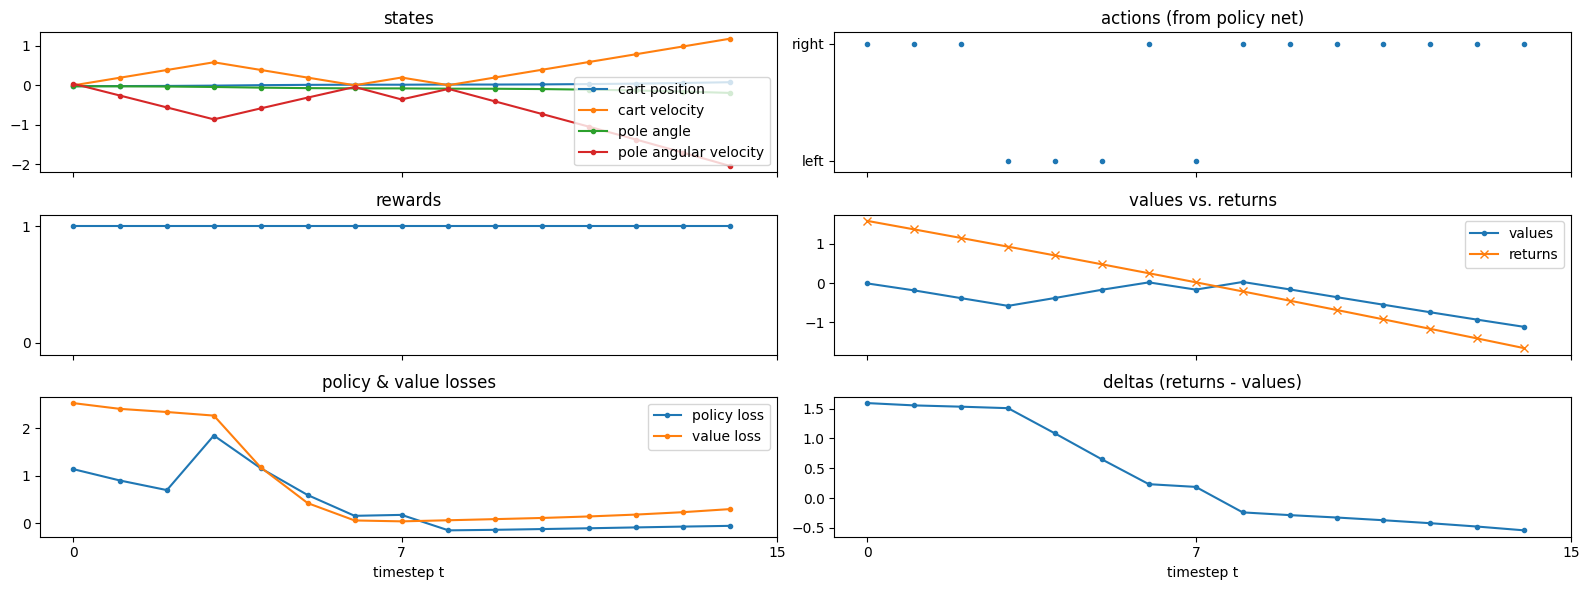

In [102]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(6)

env = gym.make('CartPole-v1')

state, _ = env.reset(seed=seed_adapter(seed_sequence))
torch.manual_seed(seed_adapter(seed_sequence))

agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)
episode = agent.generate_episode(env)
losses = agent.update(episode, gamma)
visualize_episode(gamma, episode, losses)

### The expected seed of the previous cell is:
```
seed_int 10324823579957477319
seed_int 2479505222830176779
```

### Making sure REINFORCE with baseline learns something useful
Let's train the REINFORCE with baseline agent for 200 episodes, and see what it has learned.

seed_int 3386250816931739734
seed_int 4042502035264064771


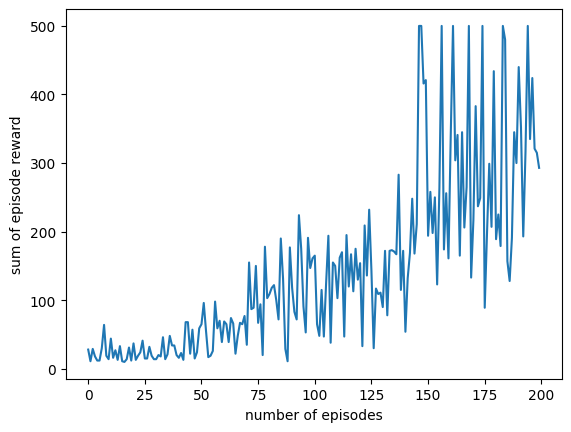

In [103]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')
state, _ = env.reset(seed=seed_adapter(seed_sequence))

torch.manual_seed(seed_adapter(seed_sequence))
agent = REINFORCE_BL_Agent(env, policy_alpha=1e-3, value_alpha=1e-3)

episode_rewards = []
for i_episode in range(200):
    episode = agent.generate_episode(env)
    losses = agent.update(episode, gamma)
    episode_rewards.append(np.sum(episode['rewards']))

fig, ax = plt.subplots()
ax.set_ylabel('sum of episode reward')
ax.set_xlabel('number of episodes')
ax.plot(episode_rewards)
plt.show()

### The expected seed of the previous cell is:
```
seed_int 3386250816931739734
seed_int 4042502035264064771
```

### Let's look at a generated episode, after the agent has trained for 200 episodes:
This will be a different episode, and different behavior, each time you execute this cell.<br>
The reason is that `env` was seeded in a code cell above, and its internal PRNG state is advanced, as the agent is interacting with it.<br>
If you always want the same episode generated, you need to set the seed of the `env` in the code cell below.

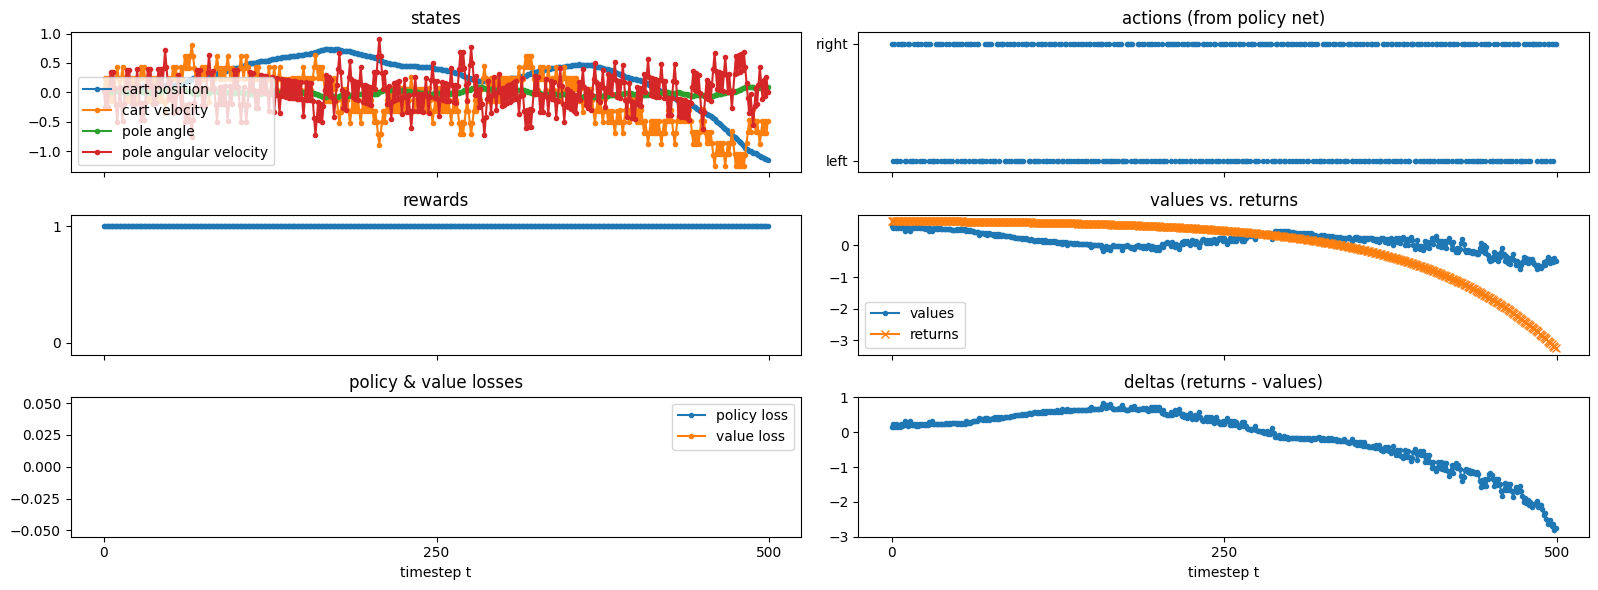

In [104]:
# i find it *really* funny that given this seed (2021 12 08), the agent trained above runs for the full 500 steps :)
seed_sequence = np.random.SeedSequence(20211208)

env = gym.make('CartPole-v1')

# state, _ = env.reset(seed=seed_adapter(seed_sequence))
# torch.manual_seed(seed_adapter(seed_sequence))

episode = agent.generate_episode(env)
visualize_episode(gamma, episode)

## (8) Run a comparison between REINFORCE and REINFORCE with Baseline

<div class="alert alert-warning">
    Run two experiments to compare REINFORCE with and without Baseline. (2 points)
</div>


Here, you will compare the performance of REINFORCE and REINFORCE with Baseline. Each algorithm needs to be run 5 times, for 500 episodes. All learn rates should be the `alpha` value given below, including `policy_alpha` and `value_alpha` for REINFORCE with Baseline.

In [106]:
gamma = 0.99
seed_sequence = np.random.SeedSequence(7)

env = gym.make('CartPole-v1')

n_runs = 5
n_episodes = 500
alpha = 1e-3

reinforce_rewards = None # use run_experiments
reinforce_bl_rewards = None

# YOUR CODE HERE
# Run REINFORCE
reinforce_rewards = run_experiments(
    seed_sequence, env, gamma, n_runs, n_episodes,
    REINFORCEAgent, {'env': env, 'alpha': alpha})

# Run REINFORCE with baseline
reinforce_bl_rewards = run_experiments(
    seed_sequence, env, gamma, n_runs, n_episodes,
    REINFORCE_BL_Agent, {'env': env, 'policy_alpha': alpha, 'value_alpha': alpha})

------------------------------------------------------------
agent_class <class '__main__.REINFORCEAgent'>
agent_params {'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>, 'alpha': 0.001}
seed_int 3386250816931739734
seed_int 4042502035264064771
run:4/5 ep:0499/500 policy_loss:13.24 avg reward last 10 episodes:365.5                                                                                                                                                                                                                                                                                                                                         
------------------------------------------------------------
agent_class <class '__main__.REINFORCE_BL_Agent'>
agent_params {'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>, 'policy_alpha': 0.001, 'value_alpha': 0.001}
seed_int 17559002276220262541
seed_int 6823953754371609207
run:4/5 ep:04

In [107]:
assert testing.is_type(reinforce_rewards, np.ndarray)
assert reinforce_rewards.shape == (n_runs, n_episodes) 

assert testing.is_type(reinforce_bl_rewards, np.ndarray)
assert reinforce_bl_rewards.shape == (n_runs, n_episodes) 

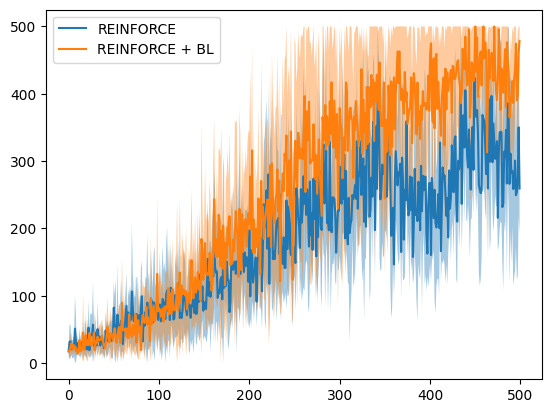

In [108]:
fig, ax = plt.subplots()
plot(ax, reinforce_rewards, label='REINFORCE')
plot(ax, reinforce_bl_rewards, label='REINFORCE + BL')
ax.legend()
plt.show()

### Theory questions
<div class="alert alert-warning">
Answer whether the following statements are true or false (1 point each question)
</div>

1. The number of $\epsilon$-greedy policies for an arbitrary but fixed choice $\epsilon$ is finte.
2. Policy gradient methods are effective in both low and high dimensional action spaces.
3. REINFORCE with baseline is considered as an actor-critic method, if we use the state value function as a baseline.
4. Actor-critic methods use bootstrapping instead of the full Monte Carlo rollout to estimate the state-action value ($q(a,s)$).

In [109]:
# store True or False
results = {
  "1" : None,
  "2" : None,
  "3" : None,
  "4" : None
}

# YOUR CODE HERE
results = {
    "1": True,  
    "2": False, 
    "3": False,  
    "4": True,  
}

In [110]:
assert testing.is_type(results['1'], bool)

In [111]:
assert testing.is_type(results['2'], bool)

In [112]:
assert testing.is_type(results['3'], bool)

In [113]:
assert testing.is_type(results['4'], bool)

<div class="alert alert-warning">
Answer the following question in **one, short sentence**. (2 points each)
</div>

- What is the major difference between policy and value based RL methods?

Policy-based RL methods learn a policy directly, while value-based RL methods estimate a value function to derive the policy


<div class="alert alert-warning">
Answer the following question in **two, short sentence** (2 points).
</div>

- Why can't we compute the performance gradient directly? How does the policy gradient theorem help? 

We can't compute the performance gradient directly because the expected return depends on the stochastic policy and environment dynamics, making it intractable to differentiate. The policy gradient theorem simplifies this by expressing the gradient in terms of the policy's log-probabilities and rewards, enabling efficient computation.